# Source Code Notebook - InceptionV3


## Google Colab Configs


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Image Conversion and Validation


### Checking of the validity of Images in the dataset


In [2]:
import cv2
import os
from pathlib import Path
# DATA_DIR = "dataset/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

# For Colab:
DATA_DIR = "/content/drive/MyDrive/dataset/AI Art vs Real Art"
import imghdr
IMAGE_EXTENSIONS = [".png", ".jpg", ".jpeg"]  # add there all your images file extensions
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in IMAGE_EXTENSIONS:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

## Data Preprocessing


### Import Tensorflow and Keras and check on available GPU


In [3]:
import sys
import tensorflow as tf
import keras
import platform
import numpy as np
print(f"Python Platform: {platform.version()}")
print(f"Python Version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print(f"GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T8112
Python Version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:51:49) [Clang 16.0.6 ]
Tensorflow version: 2.16.1
Keras version: 3.2.1

GPU is available


### Set constants for Images


In [4]:
BATCH_SIZE = 64
HEIGHT = 256
WIDTH = 256
IMAGE_SIZE = (HEIGHT, WIDTH)

### Use Keras' Preprocessing modules to split data


In [5]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    label_mode='binary',
    labels='inferred',
    color_mode='rgb',
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2,
    subset="training",
)

val_dataset = keras.preprocessing.image_dataset_from_directory(
    label_mode='binary',
    labels='inferred',
    color_mode='rgb',
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2, # use 20% as validation
    subset="validation",
)
# The target labels
class_names = train_dataset.class_names
print(class_names)

Found 912 files belonging to 2 classes.
Using 730 files for training.
Found 912 files belonging to 2 classes.
Using 182 files for validation.
['AI Art', 'Real']


2024-05-18 17:08:38.967576: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-18 17:08:38.967625: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-18 17:08:38.967639: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-18 17:08:38.967672: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-18 17:08:38.967698: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Display Sample Images


/var/folders/mp/c7pgmq8j0472f05vnx5h16000000gn/T/ipykernel_45763/1496282019.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(labels[i].numpy())])
2024-05-18 17:08:42.001909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


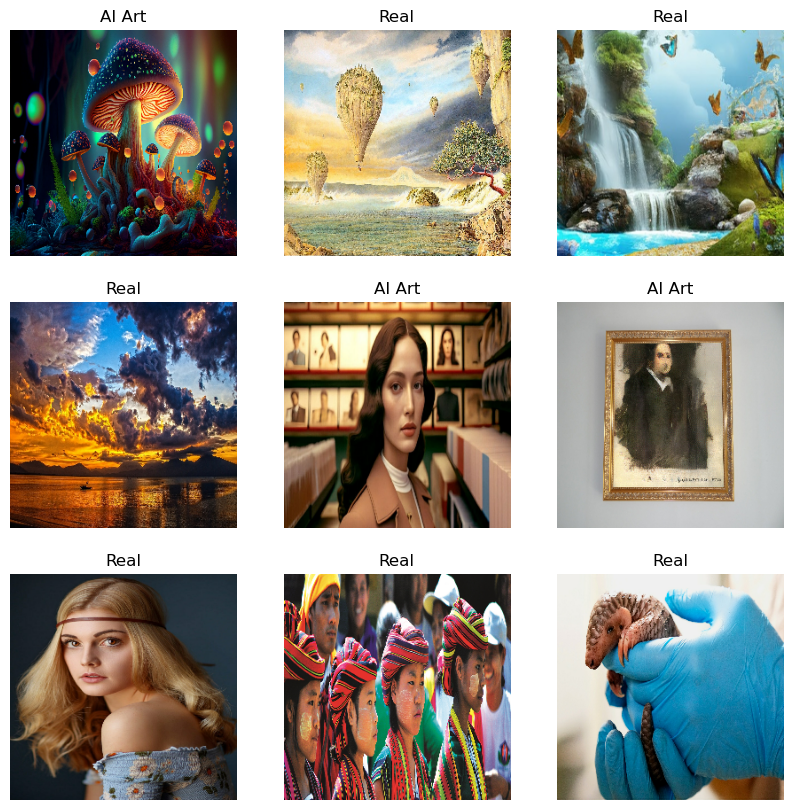

In [6]:
import matplotlib.pyplot as plt

def display_binary_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i].numpy())])
            plt.axis("off")
display_binary_images(train_dataset, class_names)

### Rescale


### Data Augmentation


In [7]:
# augmentation_layers = [
#     keras.layers.RandomFlip("horizontal_and_vertical"),
#     keras.layers.RandomRotation(0.1),
#     # keras.layers.RandomTranslation(height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3)),
#     # keras.layers.RandomZoom(height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3)),
# ]


# def data_augmentation(x):
#     for layer in augmentation_layers:
#         x = layer(x)
#     return x

# train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

### Prefetch Data for Optimization


In [8]:
from tensorflow import data as tf_data

train_dataset = train_dataset.prefetch(tf_data.AUTOTUNE).cache()
val_dataset = val_dataset.prefetch(tf_data.AUTOTUNE).cache()


### Display Data Augmentation


In [9]:
# for images, labels in train_dataset.take(1):
#     plt.figure(figsize=(10, 10))
#     first_image = images[0]
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         augmented_image = data_augmentation(np.expand_dims(first_image, 0))
#         plt.imshow(np.array(augmented_image[0]).astype("int32"))
#         plt.title(int(labels[0]))
#         plt.axis("off")


## Importing InceptionV3 and Base Training


### Import InceptionV3 as our base model


In [10]:
base_model = keras.applications.InceptionV3(
    include_top=False, # Do not include the final layer, which classifies images
    weights="imagenet",
    input_shape=(HEIGHT, WIDTH, 3),
)


### Make base model non-trainable


In [11]:
for layer in base_model.layers:
    layer.trainable = False

## Fine-Tuning the model


### Util Methods


In [12]:
# Dynamic Learning Rate
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.1
    epochs_drop = 10
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) 
        / epochs_drop))
    return lr

In [13]:
stop = keras.callbacks.EarlyStopping(
    patience=5, 
    restore_best_weights=True, 
    monitor="val_loss", 
    start_from_epoch=5, 
    verbose=1)

callbacks = [
    stop,
    keras.callbacks.LearningRateScheduler(lr_schedule),
]

### Create new Model on Top


In [14]:
from keras import layers
# Starting layers
inputs = keras.Input(shape=(HEIGHT, WIDTH, 3))
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model(inputs, training=False) # run in inference mode

x = layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = layers.Dense(2056, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

### Compile the Model


In [15]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary(show_trainable=True)

stop = keras.callbacks.EarlyStopping(
    patience=5, 
    restore_best_weights=True, 
    monitor="val_loss", 
    start_from_epoch=5, 
    verbose=1)

callbacks = [
    stop,
    keras.callbacks.LearningRateScheduler(lr_schedule),
]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ inception_v3 (Functional)   │ (None, 6, 6, 2048)    │ 21,802,784 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 2056)          │  4,212,744 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 2056)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 1)             │      2,057 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 26,017,585 (99.25 MB)

 Trainable params: 4,214,801 (16.08 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

### Train the Top Layer


In [16]:
EPOCHS = 50

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics= [keras.metrics.BinaryAccuracy()],
)

print("Fitting the top layer of the model")

model.fit(train_dataset, 
          epochs=EPOCHS, 
          validation_data=val_dataset,
          callbacks=callbacks,
)

Fitting the top layer of the model
Epoch 1/50


2024-05-18 17:08:44.798799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - binary_accuracy: 0.5321 - loss: 77.7173 - val_binary_accuracy: 0.5220 - val_loss: 16.5218 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 465ms/step - binary_accuracy: 0.5562 - loss: 15.4195 - val_binary_accuracy: 0.6044 - val_loss: 2.5363 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 440ms/step - binary_accuracy: 0.6001 - loss: 7.2324 - val_binary_accuracy: 0.6319 - val_loss: 1.6367 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 475ms/step - binary_accuracy: 0.5641 - loss: 4.8906 - val_binary_accuracy: 0.6099 - val_loss: 1.3875 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 441ms/step - binary_accuracy: 0.5957 - loss: 3.3986 - val_binary_accuracy: 0.5934 - val_loss: 1.2146 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 483ms/step - binary_accuracy: 0.6404 - loss: 1.9319 - val_binary_accuracy: 0.5110 - val_loss: 1.0782 - learning_rate: 0.0010
Epoch 7/50
12/

## Fine Tuning the Model


### Util Methods


In [17]:
# Dynamic Learning Rate
def fine_tuned_lr_schedule(epoch):
    initial_lr = 0.00001
    drop = 0.1
    epochs_drop = 10
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) 
        / epochs_drop))
    return lr

In [18]:
stop = keras.callbacks.EarlyStopping(
    patience=5, 
    restore_best_weights=True, 
    monitor="val_loss", 
    start_from_epoch=5, 
    verbose=1)

callbacks = [
    stop,
    keras.callbacks.LearningRateScheduler(fine_tuned_lr_schedule),
]

### Unfreeze Layers


In [19]:
for layer in base_model.layers:
    layer.trainable = True

In [20]:
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.00001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics= [keras.metrics.BinaryAccuracy()],
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ inception_v3 (Functional)   │ (None, 6, 6, 2048)    │ 21,802,784 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 2056)          │  4,212,744 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 2056)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 1)             │      2,057 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 30,232,388 (115.33 MB)

 Trainable params: 25,983,153 (99.12 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 4,214,803 (16.08 MB)

In [21]:
print("Fitting the end-end model")
fine_tuned_model = model.fit(train_dataset, 
          epochs=EPOCHS, 
          validation_data=val_dataset,
          callbacks=callbacks,
)

Fitting the end-end model
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 204s 12s/step - binary_accuracy: 0.5082 - loss: 0.6933 - val_binary_accuracy: 0.5165 - val_loss: 0.6926 - learning_rate: 1.0000e-05
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 102s 8s/step - binary_accuracy: 0.5675 - loss: 0.6881 - val_binary_accuracy: 0.5330 - val_loss: 0.6930 - learning_rate: 1.0000e-05
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 111s 9s/step - binary_accuracy: 0.5583 - loss: 0.6877 - val_binary_accuracy: 0.5055 - val_loss: 0.6940 - learning_rate: 1.0000e-05
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 98s 8s/step - binary_accuracy: 0.5956 - loss: 0.6849 - val_binary_accuracy: 0.5165 - val_loss: 0.6930 - learning_rate: 1.0000e-05
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 108s 8s/step - binary_accuracy: 0.6206 - loss: 0.6823 - val_binary_accuracy: 0.5385 - val_loss: 0.6907 - learning_rate: 1.0000e-05
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 112s 9s/step - binary_accuracy: 0.6023 - loss: 0.6834 - val_binary_accuracy: 0.5055 - val_l

## Evaluation of the Model


### Predicting a Specific Image


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predictions: [0.47633198]
The predicted class for the image dataset/AI Art vs Real Art/Real/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpeg is: AI Art


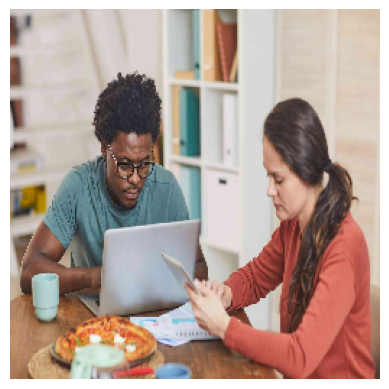

In [22]:
# img_path = "dataset/AI Art vs Real Art/Real/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpeg"
img_path = "/content/drive/MyDrive/dataset/AI Art vs Real Art/Real/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpeg"

img = keras.preprocessing.image.load_img(img_path, 
                                            target_size=(HEIGHT, WIDTH))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]

print(f"Predictions: {predictions}")

# Interpret the prediction (assuming binary classification with 0 for Real Art and 1 for AI Art)
# Ensure predictions is in the correct format
if len(predictions.shape) == 1:
    predicted_class = 'Real Art' if predictions[0] > 0.5 else 'AI Art'
else:
    predicted_class = 'Real Art' if predictions[0][0] > 0.5 else 'AI Art'

# Create a string with the predicted label
result_string = f'The predicted class for the image {img_path} is: {predicted_class}'
print(result_string)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

### Predicting a Random Image


dataset/AI Art vs Real Art/AI Art/AiArtData
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
Predictions: [0.49227372]
The predicted class for the image 1IGvTkw48FTa1pO33VbG4eA.png is: AI Art


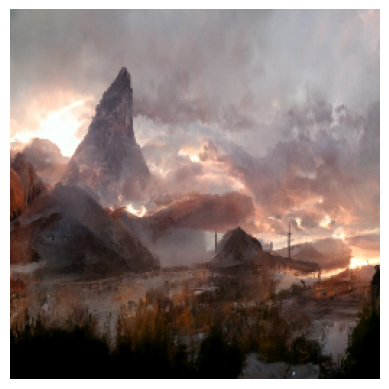

In [23]:
import os
import random
folder_number = random.randint(1, 2)  # Generate a random number between 1-3
# if folder_number == 1:
#     dataset_dir = "dataset/AI Art vs Real Art/AI Art/AiArtData"
# else:
#     dataset_dir = "dataset/AI Art vs Real Art/Real/RealArt"
    
if folder_number == 1:
    dataset_dir = "/content/drive/MyDrive/dataset/AI Art vs Real Art/AI Art/AiArtData"
else:
    dataset_dir = "/content/drive/MyDrive/dataset/AI Art vs Real Art/Real/RealArt"
print(dataset_dir)
file_list = os.listdir(dataset_dir)

random_file = random.choice(file_list)
image_path = os.path.join(dataset_dir, random_file)

img = tf.keras.preprocessing.image.load_img(image_path, 
                                            target_size=(HEIGHT, WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]

print(f"Predictions: {predictions}")

# Interpret the prediction (assuming binary classification with 0 for Real Art and 1 for AI Art)
# Ensure predictions is in the correct format
if len(predictions.shape) == 1:
    predicted_class = 'Real Art' if predictions[0] > 0.5 else 'AI Art'
else:
    predicted_class = 'Real Art' if predictions[0][0] > 0.5 else 'AI Art'

# Create a string with the predicted label
result_string = f'The predicted class for the image {random_file} is: {predicted_class}'
print(result_string)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

### Visualization in terms of Epochs


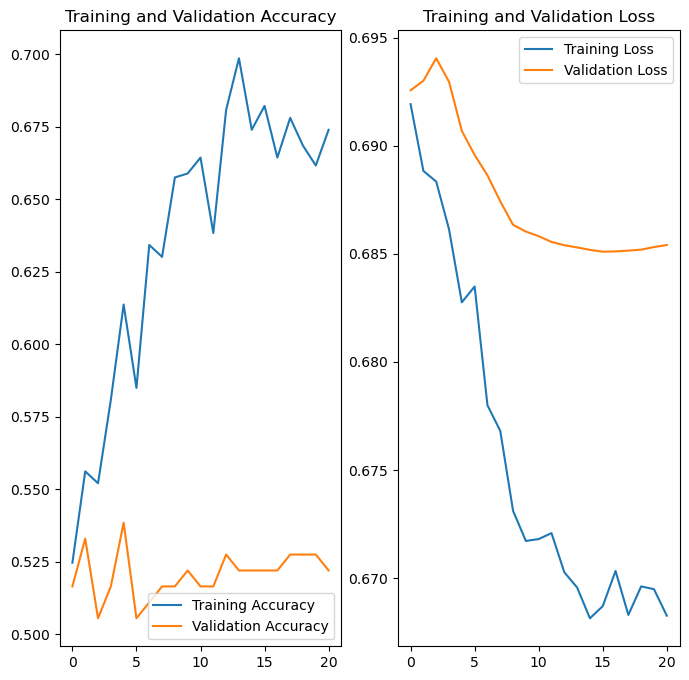

In [24]:
acc = fine_tuned_model.history['binary_accuracy']
val_acc = fine_tuned_model.history['val_binary_accuracy']

loss = fine_tuned_model.history['loss']
val_loss = fine_tuned_model.history['val_loss']
if stop.stopped_epoch != 0:
    epochs_range = range(stop.stopped_epoch+1)
else:
    epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()